# Data 501 Project - Working with Kickstarter Data

### Introduction


For this project, I chose a dataset from Kaggle of [Kickstarter](https://www.kickstarter.com/) projects, which is owned by Mickaël Mouillé and can be found [here](https://www.kaggle.com/datasets/kemical/kickstarter-projects?select=ks-projects-201612.csv). This notebook shows my data cleaning and data visualisation process to provide some interesting insights about this data.

I'm completing this project as part of my Data Consultant training at Sparta Global. This notebook aims to demonstrate the following:
- My understanding of essential Python libraries for data (numpy, pandas, matplotlib, seaborn)
- My ability to clean and process unfamiliar and messy datasets
- My Python programming skills, including writing functions and understanding of OOP and methods
- My ability to generate appropriate visualisations for a dataset
- My ability to use Markdown and Jupyter notebooks
- My writing skills, including documentation, scientific writing, and "data storytelling"

In this notebook I will outline my step-by-step process through importing the data, cleaning it, presenting it for visualisation, and some interesting insights I was able to glean. 

The first section, ["Bringing in the Data"](#bringing-in-the-data), shows the libraries used and the code to bring in the data.

The second section, ["Data Cleaning"](#data-cleaning), goes through my process of cleaning the data, including having to address shifted rows and corrupted column entries, and writing a script to calculate some missing values. 

In the final section, ["Data Analysis"](#data-analysis), I present five plots that I think show interesting things about our data. These visualisations indicate that the project categories receiving the most money in pledges are Technology, Games, and Design, and that the countries spending the most money on Kickstarter projects are France and the USA. 

### Bringing in the Data

In [3]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
kickstarter_data = pd.read_csv("Data Folder/ks-projects-201612.csv", encoding = "ISO-8859-1")
# There are some non-standard characters in the dataset so I've had to use a different kind of encoding

kickstarter_data.head()

C:\Users\hilld\AppData\Local\Temp\ipykernel_5960\431420457.py:1: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  kickstarter_data = pd.read_csv("Data Folder/ks-projects-201612.csv", encoding = "ISO-8859-1")


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [5]:
kickstarter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              323750 non-null  int64  
 1   name            323746 non-null  object 
 2   category        323745 non-null  object 
 3   main_category   323750 non-null  object 
 4   currency        323750 non-null  object 
 5   deadline        323750 non-null  object 
 6   goal            323750 non-null  object 
 7   launched        323750 non-null  object 
 8   pledged         323750 non-null  object 
 9   state           323750 non-null  object 
 10  backers         323750 non-null  object 
 11  country         323750 non-null  object 
 12  usd pledged     319960 non-null  object 
 13  Unnamed: 13     625 non-null     object 
 14  Unnamed: 14     12 non-null      object 
 15  Unnamed: 15     4 non-null       object 
 16  Unnamed: 16     1 non-null       float64
dtypes: float64

### Data Cleaning

The data had a number of problems which I needed to rectify before proceeding to analysis. 

First, the column name strings all had an additional space at the end. I was able to use the `.map()` method to remove these. Second, 4 of the rows had no name for the project, so these were simply removed.

In [6]:
# Copy the data to prevent overwriting
cleaned_data = kickstarter_data.copy()

# Remove space from the end of column names
cleaned_data.columns = cleaned_data.columns.map(lambda c: str(c)[:-1])

# Remove nameless entries
cleaned_data = cleaned_data[~cleaned_data.name.isnull()]

Second, it was immediately apparent to me that there were 4 additional columns at the end, for which the majority of the data had no entries. Upon some further investigation, I discovered that a number of the rows had been **shifted** so that the entries actually overflowed into these additional columns. This was a significant problem as the columns ended up with the wrong datatypes (launch dates in the amount of money pledged column, for instance).

Given that there didn't seem to be many of these rows, for the sake of simplicity I thought it would be best to just remove them rather than try to fix the offsets (only about 800 rows out of >300,000).

In [7]:
# Get rid of shifted rows for simplicity
cleaned_data = cleaned_data[cleaned_data.iloc[:,13].isnull()]

# Get rid of empty columns
cleaned_data = cleaned_data.iloc[:, 0:13]

Annoyingly, this hadn't removed of all the shifted rows - some of them had been shifted and were *also* missing the data at the end, meaning they could only be detected when I tried to change the column data types. Using some logic along with the `pd.to_numeric()` function helped me identify the last problematic rows.

In [8]:
# Identifying and removing further columns with shifted data
cleaned_data = cleaned_data[
    ~pd.to_numeric(cleaned_data['goal'], errors='coerce').isnull() 
    ] # The tilde (~) inverts the boolean mask, giving us only the numerical (non-null) rows

Next, I wanted to change all the columns to their appropriate type, both for neatness and also to potentially facilitate future analysis.

In [9]:
# Manually changing column data types
cleaned_data['goal'] = pd.to_numeric(cleaned_data['goal'])
cleaned_data['pledged'] = pd.to_numeric(cleaned_data['pledged'])
cleaned_data['usd pledged'] = pd.to_numeric(cleaned_data['usd pledged'])
cleaned_data['backers'] = pd.to_numeric(cleaned_data['backers'])

cleaned_data['deadline'] = pd.to_datetime(cleaned_data['deadline'])
cleaned_data['launched'] = pd.to_datetime(cleaned_data['launched'])

cleaned_data['country'] = cleaned_data['country'].astype("category")
cleaned_data['category'] = cleaned_data['category'].astype("category")


cleaned_data.info() # Checking everything has worked thus far

<class 'pandas.core.frame.DataFrame'>
Index: 323114 entries, 0 to 323749
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             323114 non-null  int64         
 1   name           323114 non-null  object        
 2   category       323114 non-null  category      
 3   main_category  323114 non-null  object        
 4   currency       323114 non-null  object        
 5   deadline       323114 non-null  datetime64[ns]
 6   goal           323114 non-null  float64       
 7   launched       323114 non-null  datetime64[ns]
 8   pledged        323114 non-null  float64       
 9   state          323114 non-null  object        
 10  backers        323114 non-null  int64         
 11  country        323114 non-null  category      
 12  usd pledged    319324 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 30.5+ MB


The cleaning is still not complete; there's a disparity in the number of non-null "usd pledged" values and all the other columns. Looking at the data, we can see that for a number of entries, no USD pledged value has been calculated. This is no problem though as we have both the currencies and the non-USD pledged amount - writing a function to use with the `.apply()` method should sort this.

In [10]:
cleaned_data[cleaned_data['usd pledged'].isna()].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
150,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20 06:59:00,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,""0",NaN
287,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25 23:00:00,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,""0",NaN
549,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09 21:06:13,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,""0",NaN
561,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26 10:59:00,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,""0",NaN
650,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21 06:00:00,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,""0",NaN


Something I needed to know first - what currencies are represented in the dataset among the entries without a 'usd pledged' value?

In [11]:
# Addressing missing USD pledged values - find what currencies are present
cleaned_data[cleaned_data['usd pledged'].isna()].groupby('currency')['currency'].count()

currency
AUD     111
CAD     205
CHF       7
DKK      16
EUR     186
GBP     459
NOK      14
NZD      28
SEK      31
USD    2733
Name: currency, dtype: int64

With this information, I was able to go online and find contemporary currency conversion data for the dataset. Once I had created a dictionary with the conversion values, I wrote a function that would fill the missing values in the 'usd pledged' column with the accurate value. 

In [12]:
# Create dictionary with USD conversion rate for 2017-02-04 (latest deadline in dataset)
currency_dict = {
    'AUD':0.76775,
    'CAD':0.76766,
    'CHF':1.00823,
    'DKK':0.14496,
    'EUR':1.07864,
    'GBP':1.24879,
    'NOK':0.12186,
    'NZD':0.73213,
    'SEK':0.11407,
    'USD':1
}


def currency_convert(row):
    if pd.notna(row['usd pledged']): # If there's already a value, we should leave it
        return row
    elif row['currency'] == 'USD': # If there's no value but the currency is USD, just used the 'pledged' value
        row['usd pledged'] = row['pledged']
    else:
        row['usd pledged'] = float(row['pledged']) * float(currency_dict[row['currency']]) # References the dic and does the calculation
    return row

cleaned_data = cleaned_data.apply(currency_convert, axis=1)

# Footnote: this cell takes ~15s to run, I imagine there's a faster way to code this that doesn't pass
# the entire df to the function but I didn't want to spend ages optimizing it. 

Another problem that has come up is that one of the country codes appears to be incorrect:

In [13]:
cleaned_data.groupby('country').country.count()

country
AT         377
AU        6236
BE         402
CA       11992
CH         471
DE        2684
DK         825
ES        1372
FR        1910
GB       27508
HK          97
IE         575
IT        1750
LU          40
MX         214
N,"0      3790
NL        2259
NO         526
NZ        1136
SE        1269
SG         119
US      257562
Name: country, dtype: int64

Looking at the dataset, the entries from `N, "0` appeared to all use different currencies. While I considered inferring the missing values based on the currencies used, it may not necessarily be the case that projects launched in a certain currency are from a country using that currency. As such, I replaced the broken code with `XX` to show that these were invalid or otherwise missing:

In [14]:
cleaned_data['country'] = cleaned_data['country'].replace('N,"0', 'XX')
# A quick footnote - the entries with a broken country code seemingly corresponded with the entries
# without a 'usd pledged' value. It's possible there was some mistake with the delimiters or the data
# were overlapping somehow - either way I feel I've resolved it as well as possible, and it's a very
# limited number of rows.

I also discovered when trying to begin data analysis that for some reason multiple projects have launch dates in 1970, surprising given that [Kickstarter began in 2009](https://en.wikipedia.org/wiki/Kickstarter#:~:text=Launched,15%20years%20ago). We'll assume these were the first projects on Kickstarter, and set their launch date to `2009-04-28 01:00:00`:

In [15]:
cleaned_data.loc[
    cleaned_data.launched == pd.to_datetime('1970-01-01 01:00:00'), 'launched' # Using loc to find the values
    ] = pd.to_datetime('2009-04-28 01:00:00')

Finally, a check for duplicated rows:

In [16]:
cleaned_data[cleaned_data.duplicated].ID.count()

np.int64(0)

Great! Our data cleaning is now complete. Let's see some information about our cleaned dataset:

In [17]:
cleaned_data.describe()

,ID,deadline,goal,launched,pledged,backers,usd pledged
count,3.231140e+05,323114,3.231140e+05,323114,3.231140e+05,323114.000000,3.231140e+05
mean,1.074902e+09,2014-05-18 07:44:31.637319680,4.715236e+04,2014-04-13 21:54:14.045290496,8.696838e+03,101.636082,7.789687e+03
min,5.971000e+03,2009-05-03 08:59:59,1.000000e-02,2009-04-21 21:02:48,0.000000e+00,0.000000,0.000000e+00
25%,5.375717e+08,2013-02-18 21:55:05.500000,2.000000e+03,2013-01-17 07:19:15.750000128,3.000000e+01,2.000000,2.500000e+01
50%,1.075767e+09,2014-09-07 17:59:42,5.000000e+03,2014-08-05 01:17:05.500000,6.100000e+02,12.000000,5.360000e+02
75%,1.611025e+09,2015-09-09 16:37:25.500000,1.500000e+04,2015-08-06 20:54:55.249999872,3.938000e+03,55.000000,3.578249e+03
max,2.147476e+09,2017-02-04 08:54:55,1.000000e+08,2016-12-06 10:18:31,2.033899e+07,219382.000000,2.033899e+07
std,6.193136e+08,NaN,1.139584e+06,NaN,8.958696e+04,934.923014,8.432855e+04


### Data Analysis

##### Plot 1: Scatterplot
For my first plot, I wanted to show an overview of the data. This is a graph that plots each project as a point, showing when it was launched and how many backers it has. The legend shows what each of the colours correspond to. Green projects were successful, and as can be seen from the graph have more backers, while blue projects were unsuccessful, and naturally have fewer backers. (Where it says red projects are "live" - these projects were live when this data was gathered, presumably at the end of 2017.)

Text(0.5, 0, 'Date launched')

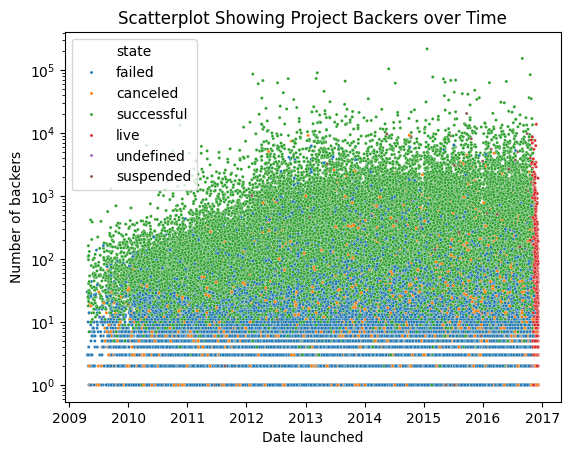

In [18]:
graph = sns.scatterplot(data=cleaned_data, x='launched', y='backers', s=5, marker='o', hue='state')
graph.set_yscale('log')
plt.title("Scatterplot Showing Project Backers over Time")
plt.ylabel("Number of backers")
plt.xlabel('Date launched')

##### Plot 2: Bar plot
My second plot is a bar plot that shows how much money each kind of project was receiving. As you can see, there are three main types of project which receive much more money than the others - games, design, and technology projects. The error bars show that this is a significant difference. 

Text(0.5, 0, 'Amount Pledged in USD')

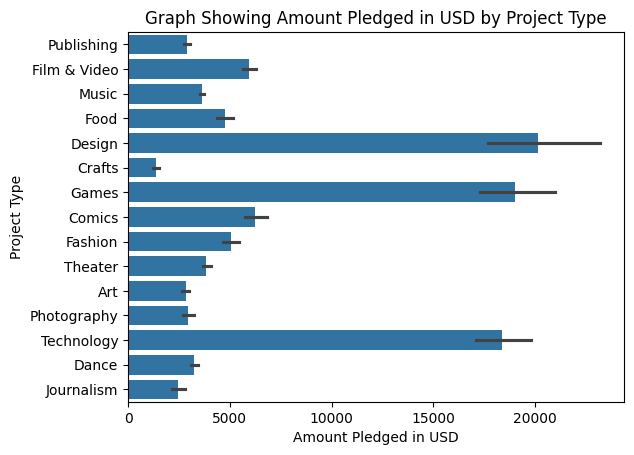

In [20]:
plot = sns.barplot(data=cleaned_data, x='usd pledged', y='main_category')

plt.title("Graph Showing Amount Pledged in USD by Project Type")
plt.ylabel("Project Type")
plt.xlabel('Amount Pledged in USD')

##### Plot 3: Heatmap

My third plot is a heatmap that shows how much money each month was given to projects for the ~7 year period of the dataset. The code required for this was a bit more complex: I had to rectangularise my data by finding the month and year for each project from the "launched" column, and run the pandas `pivot_table()` function before rendering it as a heatmap. Inspecting the graph visually, one can see that the best years for kickstarter projects were 2014 and 2015, and that pledges slowly built up over time since the project was launched. There seems to be a dramatic reduction in June of 2016 - I can't think of a reason why people suddenly stopped donating to Kickstarter projects around then.

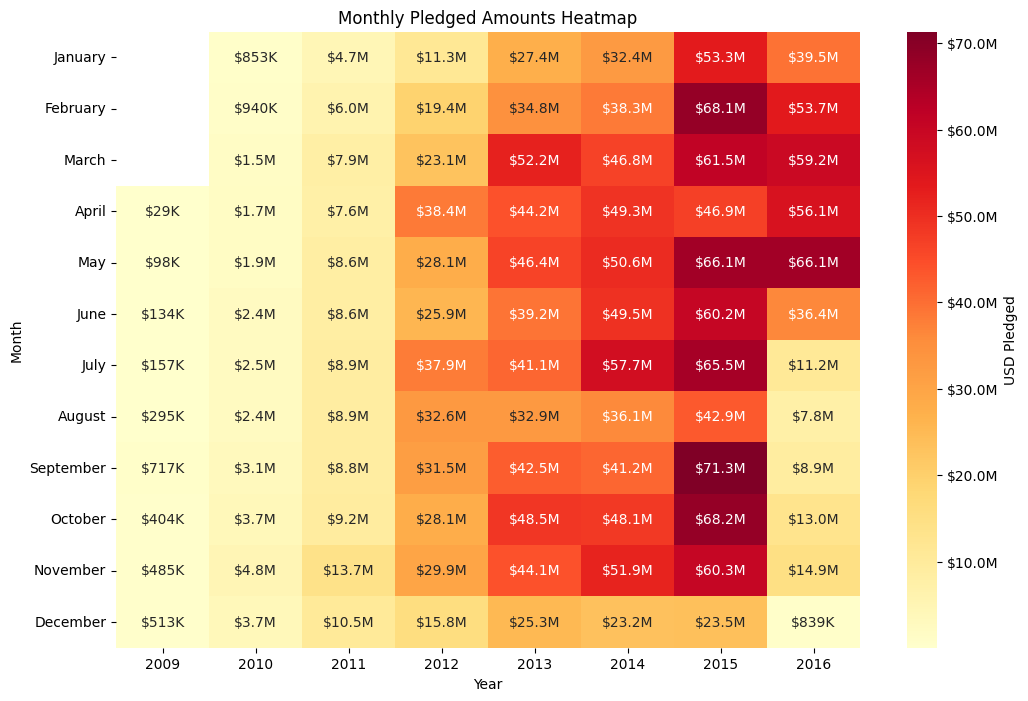

In [21]:
def create_pledged_heatmap(data, datetime_column, usd_column):
    """
    This function creates a heatmap based on our data. It first reformats the data as rectangular using
    the pivot_table() function, before passing it to matplotlib and seaborn to generate the heatmap. I have
    also had to write a function that corrects the format of the numbers, because I couldn't get the seaborn
    formatting to play nicely with the DataFrame. (Another and possibly simpler way to do this might have been
    reformatting the DataFrame to not use scientific notation, but I think this works out a bit neater)
    """

    data['year'] = data[datetime_column].dt.year
    data['month'] = data[datetime_column].dt.strftime('%B') # It would only work this way - not sure why...
    
    pivot_data = data.pivot_table(
        values=usd_column, 
        index='month',
        columns='year',
        aggfunc='sum'
        )
    
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pivot_data = pivot_data.reindex(month_order)

    # Number formatting function
    def format_value(x):
        if abs(x) >= 1e6:
            return f'${x/1e6:.1f}M'
        elif abs(x) >= 1e3:
            return f'${x/1e3:.0f}K'
        else:
            return f'${x:.0f}'

    annot_matrix = pivot_data.map(format_value) # Reformatting the numbers in the pivot table appropriately

    plt.figure(figsize=(12,8))

    sns.heatmap(
        pivot_data,
        annot=annot_matrix,
        fmt='',
        cmap='YlOrRd',
        cbar_kws={
            'label': 'USD Pledged',
            'format': lambda x, p: format_value(x) 
                  } 
    )

    plt.title('Monthly Pledged Amounts Heatmap')
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.xticks(rotation=0)
create_pledged_heatmap(cleaned_data, 'launched', 'usd pledged') # Call the function

##### Plot 4: Bar plot

My fourth graph is a bar plot, showing average amounts pledged to projects by project country. France and the USA lead the way, though the error bars suggest a large amount of variance on all of these. I perhaps could have filtered by only successful campaigns, but failed and cancelled campaigns are also valuable data to consider. 

Text(0.5, 0, 'Amount Pledged in USD')

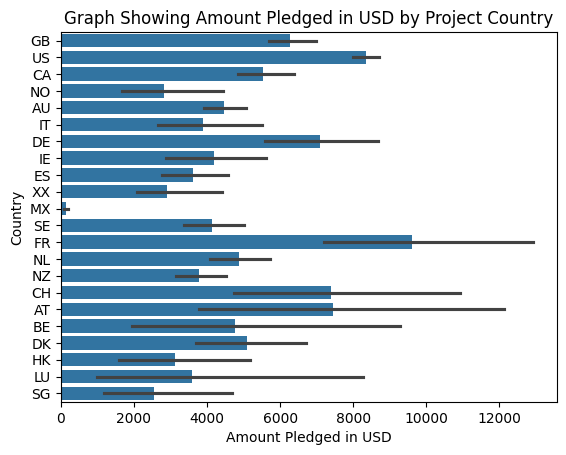

In [23]:
plot = sns.barplot(data=cleaned_data, x='usd pledged', y='country')
plt.title("Graph Showing Amount Pledged in USD by Project Country")
plt.ylabel("Country")
plt.xlabel('Amount Pledged in USD')

##### Plot 5: Violin plot

Finally, I wanted to make a violin plot to show some of the distributions in pledged amounts. I opted to look at just Hong Kong's data, given that their average pledge amounts were lower and they had fewer datapoints overall. I also wanted to look at the three leading categories of Games, Design, and Technology. As you can see from the plot, the Design and Games categories are predictably bottom-heavy in their distributions; Technology though was narrower throughout. The box-and-whisker also suggests that there were a number of very lucrative Technology projects.

Text(0.5, 0, 'Amount Pledged in USD')

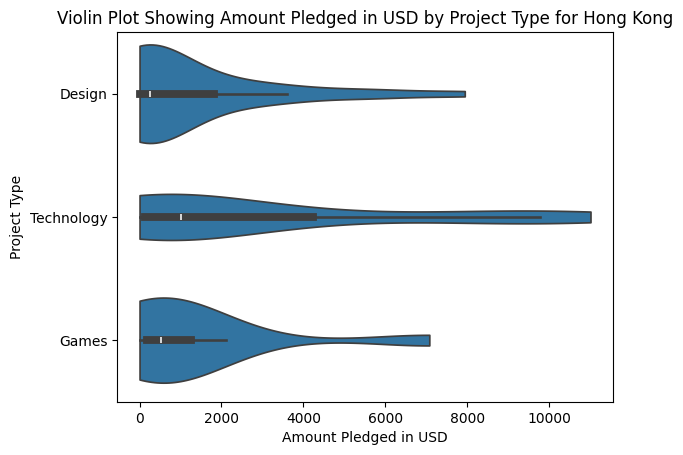

In [24]:
data_hk = cleaned_data[cleaned_data.country == 'HK']
data_hk =  data_hk[data_hk['usd pledged'] < 25000] 
# Dropping outliers that distorted the plot - there were in fact some very expensive design projects, 
# but I did this for aesthetics' sake

sns.violinplot(
    data=data_hk, 
    x='usd pledged', 
    y=(data_hk[data_hk['main_category'].isin(['Technology', 'Games', 'Design'])].main_category),
    cut=0
    )

plt.title("Violin Plot Showing Amount Pledged in USD by Project Type for Hong Kong")
plt.ylabel("Project Type")
plt.xlabel('Amount Pledged in USD')

### Conclusion

Overall, this dataset was fun to work with and I felt we were able to learn some interesting things, such as which project categories receive the most money, and which countries spend the most on Kickstarter! (The USA was no suprise, but I didn't expect France to be so far ahead.) The data cleaning was challenging, but overall I felt like I completed it satisfactorily. Seaborn was very fun to work with, and I learnt a lot about all the different visualisation options.

Hope you enjoyed reading!

~ Oscar Hill